In [2]:
%load_ext autoreload


In [3]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
import gdal
from mintpy.utils import plot as pp
from mintpy.utils import readfile, utils as ut 
import h5py
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mintpy import view
from mintpy.objects import timeseries
from operator import itemgetter 
import datetime
from datetime import timedelta
from scipy import interpolate
import matplotlib.dates as mdates
from minopy.objects.invert_pixel import process_pixel 
from scipy import stats
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.colors as mcolors

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


center = 0
divnorm = mcolors.TwoSlopeNorm(vmin=0,vcenter=0.3, vmax=1)
hex_list = ['#7B0099','#DF2A8E','#ff7b25', '#ffcc5c', '#ffeead']
cmapc=get_continuous_cmap(hex_list)
normc=divnorm

In [4]:
gps_file = './GPS_data/HUSB.tenv3.txt'
file1 = open(gps_file,"r") 
lines_husb = file1.readlines()
file1.close()


indx = np.hstack([1, np.arange(6,13), np.arange(14,17)]).astype(int)
gps_points_husb = []
for t in lines_husb:
        A = t.split()
        gps_points_husb.append(itemgetter(*indx)(A))
        

gps_file = './GPS_data/BEND.tenv3.txt'
file1 = open(gps_file,"r") 
lines_bend = file1.readlines()
file1.close()

indx = np.hstack([1, np.arange(6,13), np.arange(14,17)]).astype(int)
gps_points_bend = []
for t in lines_bend:
        A = t.split()
        gps_points_bend.append(itemgetter(*indx)(A))


In [5]:
xx_husb= [datetime.datetime.strptime(i[0], '%y%b%d') for i in gps_points_husb[1:]]
xx_bend = [datetime.datetime.strptime(i[0], '%y%b%d') for i in gps_points_bend[1:]]

m1, m2 = np.min(xx_husb), np.max(xx_husb)
h1,h2 = np.min(xx_bend), np.max(xx_bend)

val = np.max([m1,h1])
ind1_husb = xx_husb.index(val)
ind1_bend = xx_bend.index(val)

val = np.min([m2,h2])
ind2_husb = xx_husb.index(val)
ind2_bend = xx_bend.index(val)

xx_husb = xx_husb[ind1_husb:ind2_husb]
xx_bend = xx_bend[ind1_bend:ind2_bend]

xx_husb_d = [(x-xx_husb[0]).days for x in xx_husb]
xx_bend_d = [(x-xx_husb[0]).days for x in xx_bend]


E_husb = np.array([float(i[3])*100 for i in gps_points_husb[1:]])[ind1_husb:ind2_husb]
N_husb = np.array([float(i[5])*100 for i in gps_points_husb[1:]])[ind1_husb:ind2_husb]
U_husb = np.array([float(i[7])*100 for i in gps_points_husb[1:]])[ind1_husb:ind2_husb]
#dlos_minopy_husb = (N*np.sin(azangle_minopy) - E*np.cos(azangle_minopy))*np.sin(incangle_minopy) + U*np.cos(incangle_minopy)
#dlos_mintpy_husb = (N*np.sin(azangle_mintpy) - E*np.cos(azangle_mintpy))*np.sin(incangle_mintpy) + U*np.cos(incangle_mintpy)


E_bend = np.array([float(i[3])*100 for i in gps_points_bend[1:]])[ind1_bend:ind2_bend]
N_bend = np.array([float(i[5])*100 for i in gps_points_bend[1:]])[ind1_bend:ind2_bend]
U_bend = np.array([float(i[7])*100 for i in gps_points_bend[1:]])[ind1_bend:ind2_bend]


f = interpolate.interp1d(xx_bend_d, U_bend)
U_husb_intp = f(xx_husb_d)



Text(0.5, 0, 'Date [Year]')

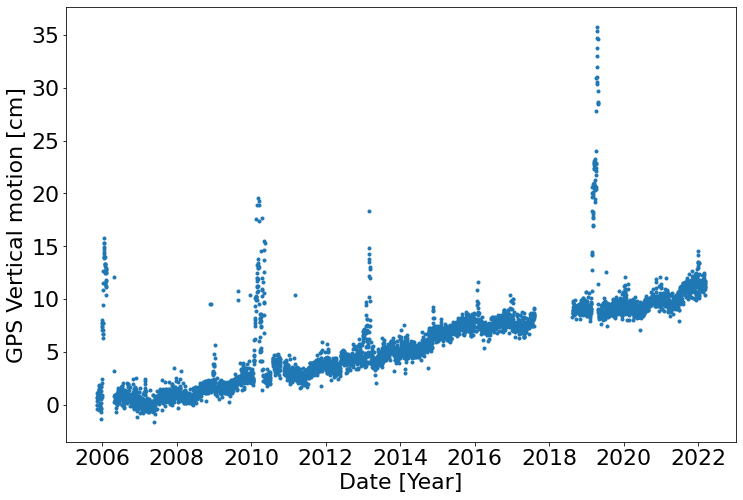

In [10]:
plt.rcParams["font.size"] = "22"
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

axs.plot(xx_husb, U_husb - U_husb_intp - (U_husb - U_husb_intp)[0], '.')

axs.set_ylabel('GPS Vertical motion [cm]')
axs.set_xlabel('Date [Year]')

